### Tennis dataset

This notebook is broken up into 3 parts
1. Cleaning/ Preprocessing
2. Feature Generation
3. Exploration of Features
4. Model Selection

# Data Cleaning

In this section, I examine the intial dataset
this includes handling of null values, dealing will categorical data

In [12]:
import pandas as pd
import tqdm
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta

In [13]:
df = pd.DataFrame()

for i in range(2001,2020):
    filename = f'atp_matches_{i}.csv'
    curr = pd.read_csv(filename)
    df = pd.concat([df, curr])

df = df.reset_index()

/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [14]:
print(df.shape)
print(df.columns)

(58192, 50)
Index(['index', 'best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
       'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt',
       'loser_age', 'loser_entry', 'loser_hand', 'loser_ht', 'loser_id',
       'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points',
       'loser_seed', 'match_num', 'minutes', 'round', 'score', 'surface',
       'tourney_date', 'tourney_id', 'tourney_level', 'tourney_name',
       'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced',
       'w_bpSaved', 'w_df', 'w_svpt', 'winner_age', 'winner_entry',
       'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_name',
       'winner_rank', 'winner_rank_points', 'winner_seed'],
      dtype='object')


Preprocessing
Keep relevant features
Clean and categorize data

Several fields contain null values so they will need to be handled


In [15]:
print(df.isna().sum())

index                     0
best_of                   0
draw_size             55411
l_1stIn                5353
l_1stWon               5353
l_2ndWon               5353
l_SvGms                5353
l_ace                  5353
l_bpFaced              5353
l_bpSaved              5353
l_df                   5353
l_svpt                 5353
loser_age                31
loser_entry           46747
loser_hand               46
loser_ht               7981
loser_id                  0
loser_ioc                 0
loser_name                0
loser_rank             1214
loser_rank_points      1214
loser_seed            44894
match_num                 0
minutes                6656
round                     0
score                     1
surface                 118
tourney_date              0
tourney_id                0
tourney_level             0
tourney_name              0
w_1stIn                5353
w_1stWon               5353
w_2ndWon               5353
w_SvGms                5353
w_ace               

In [16]:
#handle missing values for player specific data
df['loser_age'].fillna((df['loser_age'].mean()), inplace=True)
df['loser_ht'].fillna((df['loser_ht'].mean()), inplace=True)
df['loser_hand'].fillna('R', inplace=True)
df['loser_entry'].fillna('REG', inplace=True)
df['loser_rank'].fillna(1000, inplace=True)

df['winner_age'].fillna((df['loser_age'].mean()), inplace=True)
df['winner_ht'].fillna((df['winner_ht'].mean()), inplace=True)
df['winner_hand'].fillna('R', inplace=True)
df['winner_entry'].fillna('REG', inplace=True)
df['winner_rank'].fillna(1000, inplace=True)

In [17]:
#remove retirement and walkover matches for more accurate data
df = df[df['score'] != 'W/O']
df = df[~df.score.str.contains("RET", na=False)]

#Remove Davis Cup matches due to lack of point level data
df = df[df['tourney_level'] != 'D']

In [18]:
#Remove columns not useful for final dataset
drop_cols = ['winner_rank_points', 'winner_seed', 'minutes', 'draw_size', 'loser_rank_points', 'loser_seed', 
             'winner_ioc', 'loser_ioc',  ]
df = df.drop(drop_cols, axis = 1)
df = df.dropna()

In [19]:
#convert date to datetime
df['tourney_date'] = df['tourney_date'].astype(str)
df['tourney_date'] = pd.to_datetime(df['tourney_date'])

In [20]:
#Assign numbers to rounds for the model to train

df.loc[(df['round'] == 'R128') | (df['round'] == 'RR') | (df['round'] == 'BR'), ['round']] = 1
df.loc[df['round'] == 'R64', ['round']] = 2
df.loc[df['round'] == 'R32', ['round']] = 3
df.loc[df['round'] == 'R16', ['round']] = 4
df.loc[df['round'] == 'QF', ['round']] = 5
df.loc[df['round'] == 'SF', ['round']] = 6
df.loc[df['round'] == 'F', ['round']] = 7

In [21]:
#Create a dummy variable for left-handedness 
df.loc[df['loser_hand'] == 'L', ['loser_hand']] = 1
df.loc[df['loser_hand'] == 'R', ['loser_hand']] = 0

df.loc[df['winner_hand'] == 'L', ['winner_hand']] = 1
df.loc[df['winner_hand'] == 'R', ['winner_hand']] = 0

In [22]:
#Create dummy vars for whether a player is a wildcard or a qualifer
df['w_wildcard'] = 0
df['w_qualifier'] = 0

df['l_wildcard'] = 0
df['l_qualifier'] = 0

df.loc[df['winner_entry'] == 'WC', ['w_wildcard']] = 1
df.loc[(df['winner_entry'] == 'Q') | (df['winner_entry'] == 'LL'), ['w_qualifier']] = 1

df.loc[df['loser_entry'] == 'WC', ['l_wildcard']] = 1
df.loc[(df['loser_entry'] == 'Q') | (df['loser_entry'] == 'LL'), ['l_qualifier']] = 1


In [23]:
#create dummy variables for each surface

df['is_clay'] = 0
df['is_hard'] = 0
df['is_grass'] = 0
df['is_carpet'] = 0

df.loc[df['surface'] == 'Hard', ['is_hard']] = 1
df.loc[df['surface'] == 'Grass', ['is_grass']] = 1
df.loc[df['surface'] == 'Clay', ['is_clay']] = 1
df.loc[df['surface'] == 'Carpet', ['is_carpet']] = 1

In [24]:
#assign numerical values to tournament values

df.loc[df['tourney_level'] == 'G', ['tourney_level']] = 2000
df.loc[df['tourney_level'] == 'F', ['tourney_level']] = 1500
df.loc[df['tourney_level'] == 'M', ['tourney_level']] = 1000
df.loc[df['tourney_level'] == 'A', ['tourney_level']] = 500

In [25]:
#assign dummy variables for best of 5 set matches
df.loc[df['best_of'] == 3, ['best_of']] = 0
df.loc[df['best_of'] == 5, ['best_of']] = 1

In [26]:
df.shape

(50395, 50)

In [27]:
df.describe()

,index,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_ht,loser_id,loser_rank,match_num,round,tourney_level,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,w_wildcard,w_qualifier,l_wildcard,l_qualifier,is_clay,is_hard,is_grass,is_carpet
count,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000,50395.000000
mean,1550.303205,0.184681,48.767775,32.594444,15.171584,12.405973,5.170751,8.653517,4.788729,3.384383,81.574938,26.566283,185.347084,105039.784741,93.897172,80.399782,3.203473,883.490426,48.219962,36.533366,16.859748,12.613235,7.006092,5.052962,3.475801,2.657049,78.553309,26.481146,185.862473,104869.506876,58.672468,0.043119,0.085663,0.075365,0.142732,0.323564,0.538764,0.112968,0.024705
std,889.305383,0.388042,18.789162,14.121300,7.163326,4.105031,4.899582,4.089673,3.244931,2.503730,28.443354,3.906755,6.566414,7184.743569,124.127907,116.785006,1.420930,567.306975,18.431337,13.216035,6.903146,4.092058,5.571386,3.995110,3.056210,2.263673,28.416857,3.832609,6.748714,6370.736413,74.943730,0.203128,0.279869,0.263981,0.349803,0.467840,0.498500,0.316556,0.155226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.430000,163.000000,100644.000000,1.000000,1.000000,1.000000,500.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,15.820000,163.000000,100644.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,798.000000,0.000000,35.000000,22.000000,10.000000,9.000000,2.000000,6.000000,2.000000,2.000000,60.000000,23.720000,183.000000,103395.000000,35.000000,14.000000,2.000000,500.000000,35.000000,27.000000,12.000000,10.000000,3.000000,2.000000,1.000000,1.000000,57.000000,23.640000,183.000000,103484.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1557.000000,0.000000,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000,4.000000,3.000000,76.000000,26.450000,185.000000,104198.000000,65.000000,27.000000,3.000000,500.000000,45.000000,34.000000,16.000000,11.000000,6.000000,4.000000,3.000000,2.000000,73.000000,26.350000,185.000000,104198.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2291.000000,0.000000,59.000000,40.000000,19.000000,15.000000,7.000000,11.000000,7.000000,5.000000,97.000000,29.280000,188.000000,104976.000000,105.000000,92.000000,4.000000,1000.000000,58.000000,43.000000,21.000000,15.000000,9.000000,7.000000,5.000000,4.000000,94.000000,29.120000,190.000000,104918.000000,76.500000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,3298.000000,1.000000,328.000000,284.000000,101.000000,91.000000,103.000000,34.000000,25.000000,23.000000,489.000000,44.060000,208.000000,208260.000000,2159.000000,1701.000000,7.000000,2000.000000,361.000000,292.000000,82.000000,90.000000,113.000000,30.000000,24.000000,26.000000,491.000000,40.624230,208.000000,206173.000000,1890.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Adding Features
In this section I add features to the dataset

These new features keep track of historical player data and matchups



Keep track of player match-ups

For each match, add the H2H of the two players before the current match

In [28]:
def addHeadToHead(tdf):
    matchtracker = {}
    
    for id, row in tqdm.tqdm_notebook(tdf.iterrows(), total=tdf.shape[0]):
        winner = row['winner_id']
        loser = row['loser_id']
        
        #Match-ups can be stored in either order of winner, loser or loser, winner so check for both
        #Otherwise they have not played eachother yet
        if (winner, loser) in matchtracker:
            tdf.loc[id, 'w_wins_vs_opp'] = matchtracker[(winner, loser)][0]
            tdf.loc[id, 'l_wins_vs_opp'] = matchtracker[(winner, loser)][1]
            matchtracker[(winner, loser)][0]+=1
        elif (loser, winner) in matchtracker:
            tdf.loc[id, 'w_wins_vs_opp'] = matchtracker[(loser, winner)][1]
            tdf.loc[id, 'l_wins_vs_opp'] = matchtracker[(loser, winner)][0]
            matchtracker[(loser, winner)][1]+=1
        else:
            matchtracker[(winner, loser)] = [1,0]
            tdf.loc[id, 'w_wins_vs_opp'] = 0
            tdf.loc[id, 'l_wins_vs_opp'] = 0
    

### Year records

For each player in the match, get the number of wins and losses for the past year
This will allow us to examine what kind of form each player is in

Track for overall matches as well as their records on the current surface of the match

In [29]:
def addPlayerYearRecords(tdf):
    for (idx, date, winner_id, loser_id, surface) in tqdm.tqdm_notebook(tdf[['tourney_date', 'winner_id', 'loser_id', 'surface']].itertuples(), total=tdf.shape[0], leave=True):
        one_year_ago = date - relativedelta(years=1)
        one_year_df =  tdf[(tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < date)]
        
        tdf.loc[idx, 'w_1yr_wins'] = len(one_year_df[(one_year_df['winner_id'].values == winner_id)]['winner_id'])
        tdf.loc[idx, 'w_1yr_losses'] = len(one_year_df[(one_year_df['loser_id'].values == winner_id)]['winner_id'])
        
        tdf.loc[idx, 'l_1yr_wins'] = len(one_year_df[(one_year_df['winner_id'].values == loser_id)]['winner_id'])
        tdf.loc[idx, 'l_1yr_losses'] = len(one_year_df[(one_year_df['loser_id'].values == loser_id)]['winner_id'])
        
        tdf.loc[idx, 'w_1yr_wins_on_surface'] = len(one_year_df[(one_year_df['surface'].values ==surface) & (one_year_df['winner_id'].values == winner_id)]['winner_id'])
        tdf.loc[idx, 'w_1yr_losses_on_surface'] = len(one_year_df[(one_year_df['surface'].values ==surface) & (one_year_df['loser_id'].values == winner_id)]['winner_id'])
        
        tdf.loc[idx, 'l_1yr_wins_on_surface'] = len(one_year_df[(one_year_df['surface'].values ==surface) & (one_year_df['winner_id'].values == loser_id)]['winner_id'])
        tdf.loc[idx, 'l_1yr_losses_on_surface'] = len(one_year_df[(one_year_df['surface'].values ==surface) & (one_year_df['loser_id'].values == loser_id)]['winner_id'])

In [30]:
def addPlayerYearReturn(tdf):
    for idx, row in tqdm.tqdm(tdf.iterrows(), total=tdf.shape[0]):
        
        one_year_ago = row['tourney_date'] - relativedelta(years=1)
        
        #compute serve stats for the winner's past year
        wwin_df = tdf[(tdf['winner_id'] == row['winner_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        wlost_df = tdf[(tdf['loser_id'] == row['winner_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        
        winner_bp_played = wwin_df.l_bpFaced.sum() + wlost_df.w_bpFaced.sum()
        winner_bp_not_converted = wwin_df.l_bpSaved.sum() + wlost_df.w_bpSaved.sum()
        
        winner_rtpt = wwin_df.l_svpt.sum() + wlost_df.w_svpt.sum()
        winner_1st_return_lost = wwin_df.l_1stWon.sum() + wlost_df.w_1stWon.sum()
        winner_2nd_return_lost = wwin_df.l_2ndWon.sum() + wlost_df.w_2ndWon.sum()
        
        tdf.loc[idx, 'w_1yr_break_pct'] = (winner_bp_played - winner_bp_not_converted) / winner_bp_played
        tdf.loc[idx, 'w_1yr_ret_pts_won_pct'] = (winner_rtpt - winner_1st_return_lost - winner_2nd_return_lost)  / winner_rtpt
        
        #compute serve stats for the loser's last year
        lwin_df = tdf[(tdf['winner_id'] == row['loser_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        llost_df = tdf[(tdf['loser_id'] == row['loser_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        
        loser_bp_played = lwin_df.l_bpFaced.sum() + llost_df.w_bpFaced.sum()
        loser_bp_not_converted = lwin_df.l_bpSaved.sum() + llost_df.w_bpSaved.sum()
        
        loser_rtpt = lwin_df.l_svpt.sum() + llost_df.w_svpt.sum()
        loser_1st_return_lost = lwin_df.l_1stWon.sum() + llost_df.w_1stWon.sum()
        loser_2nd_return_lost = lwin_df.l_2ndWon.sum() + llost_df.w_2ndWon.sum()
        
        tdf.loc[idx, 'l_1yr_break_pct'] = (loser_bp_played - loser_bp_not_converted) / loser_bp_played
        tdf.loc[idx, 'l_1yr_ret_pts_won_pct'] = (loser_rtpt - loser_1st_return_lost - loser_2nd_return_lost)  / loser_rtpt

In [31]:
def addPlayerYearServe(tdf):
    for idx, row in tqdm.tqdm(tdf.iterrows(), total=tdf.shape[0]):
        
        one_year_ago = row['tourney_date'] - relativedelta(years=1)
        
        #compute serve stats for the winner's past year
        wwin_df = tdf[(tdf['winner_id'] == row['winner_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        wlost_df = tdf[(tdf['loser_id'] == row['winner_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        
        winner_firstin = wwin_df.w_1stIn.sum() + wlost_df.l_1stIn.sum()
        winner_svpt = wwin_df.w_svpt.sum() + wlost_df.l_svpt.sum()
        winner_ace = wwin_df.w_ace.sum() + wlost_df.l_ace.sum()
        winner_bp_faced = wwin_df.w_bpFaced.sum() + wlost_df.l_bpFaced.sum()
        winner_bp_saved = wwin_df.w_bpSaved.sum() + wlost_df.l_bpSaved.sum()
        winner_1stWon = wwin_df.w_1stWon.sum() + wlost_df.l_1stWon.sum()
        winner_2ndWon = wwin_df.w_2ndWon.sum() + wlost_df.l_2ndWon.sum()
        
        tdf.loc[idx, 'w_1yr_serve_pct'] = winner_firstin / winner_svpt
        tdf.loc[idx, 'w_1yr_ace_pct'] = winner_ace / winner_svpt
        tdf.loc[idx, 'w_1yr_bp_save_pct'] = winner_bp_saved / winner_bp_faced
        tdf.loc[idx, 'w_1yr_serve_pts_won_pct'] = (winner_1stWon + winner_2ndWon)/ winner_svpt
        
        #compute serve stats for the loser's last year
        lwin_df = tdf[(tdf['winner_id'] == row['loser_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        llost_df = tdf[(tdf['loser_id'] == row['loser_id']) & (tdf['tourney_date'] > one_year_ago) & (tdf['tourney_date'] < row['tourney_date'])]
        
        loser_firstin = lwin_df.w_1stIn.sum() + llost_df.l_1stIn.sum()
        loser_svpt = lwin_df.w_svpt.sum() + llost_df.l_svpt.sum()
        loser_ace = lwin_df.w_ace.sum() + llost_df.l_ace.sum()
        loser_bp_faced = lwin_df.w_bpFaced.sum() + llost_df.l_bpFaced.sum()
        loser_bp_saved = lwin_df.w_bpSaved.sum() + llost_df.l_bpSaved.sum()
        loser_1stWon = lwin_df.w_1stWon.sum() + llost_df.l_1stWon.sum()
        loser_2ndWon = lwin_df.w_2ndWon.sum() + llost_df.l_2ndWon.sum()
        
        tdf.loc[idx, 'l_1yr_serve_pct'] = loser_firstin / loser_svpt
        tdf.loc[idx, 'l_1yr_ace_pct'] = loser_ace / loser_svpt
        tdf.loc[idx, 'l_1yr_bp_save_pct'] = loser_bp_saved / loser_bp_faced
        tdf.loc[idx, 'l_1yr_serve_pts_won_pct'] = (loser_1stWon + loser_2ndWon)/ loser_svpt

In [32]:
addHeadToHead(df)
addPlayerYearRecords(df)
addPlayerYearReturn(df)
addPlayerYearServe(df)

/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/50395 [00:00<?, ?it/s]

/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/50395 [00:00<?, ?it/s]/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/j

In [33]:
df['w_year_win_pct'] = df['w_1yr_wins'] / (df['w_1yr_wins'] + df['w_1yr_losses'])
df['w_year_surface_win_pct'] = df['w_1yr_wins_on_surface'] / (df['w_1yr_wins_on_surface'] + df['w_1yr_losses_on_surface'])

df['l_year_win_pct'] = df['l_1yr_wins'] / (df['l_1yr_wins'] + df['l_1yr_losses'])
df['l_year_surface_win_pct'] = df['l_1yr_wins_on_surface'] / (df['l_1yr_wins_on_surface'] + df['l_1yr_losses_on_surface'])

In [34]:
df = df.rename(columns={"winner_name": "w_name", "winner_rank": "w_rank", "winner_id": "w_id", "winner_age": "w_age",
                   "winner_hand": "w_hand", "winner_ht": "w_ht"})

df = df.rename(columns={"loser_name": "l_name", "loser_rank": "l_rank", "loser_id": "l_id", "loser_age": "l_age",
                   "loser_hand": "l_hand", "loser_ht": "l_ht"})

In [57]:
df.loc[df['w_hand'] == 'U', ['w_hand']] = 0
df.loc[df['l_hand'] == 'U', ['l_hand']] = 0

df.loc[df['w_hand'] == '0', ['w_hand']] = 0
df.loc[df['w_hand'] == '1', ['w_hand']] = 1
df.loc[df['l_hand'] == '0', ['l_hand']] = 0
df.loc[df['l_hand'] == '1', ['l_hand']] = 1

/home/jzerilli/.local/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [35]:
df.to_csv('before_shuffle.csv')

In [59]:
vis_df = df[df['tourney_date'] >= '2002-01-01']

count    47407.000000
mean         0.267028
std          1.630334
min        -19.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
dtype: float64


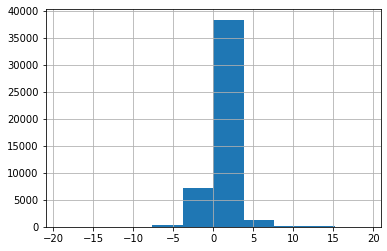

In [60]:
to_examine = (vis_df['w_wins_vs_opp'] - vis_df['l_wins_vs_opp'])

print(to_examine.describe())
(to_examine).hist()

In [61]:
for col in df.columns:
    print(col)

index
best_of
l_1stIn
l_1stWon
l_2ndWon
l_SvGms
l_ace
l_bpFaced
l_bpSaved
l_df
l_svpt
l_age
loser_entry
l_hand
l_ht
l_id
l_name
l_rank
match_num
round
score
surface
tourney_date
tourney_id
tourney_level
tourney_name
w_1stIn
w_1stWon
w_2ndWon
w_SvGms
w_ace
w_bpFaced
w_bpSaved
w_df
w_svpt
w_age
winner_entry
w_hand
w_ht
w_id
w_name
w_rank
w_wildcard
w_qualifier
l_wildcard
l_qualifier
is_clay
is_hard
is_grass
is_carpet
w_wins_vs_opp
l_wins_vs_opp
w_1yr_wins
w_1yr_losses
l_1yr_wins
l_1yr_losses
w_1yr_wins_on_surface
w_1yr_losses_on_surface
l_1yr_wins_on_surface
l_1yr_losses_on_surface
w_1yr_break_pct
w_1yr_ret_pts_won_pct
l_1yr_break_pct
l_1yr_ret_pts_won_pct
w_1yr_serve_pct
w_1yr_ace_pct
w_1yr_bp_save_pct
w_1yr_serve_pts_won_pct
l_1yr_serve_pct
l_1yr_ace_pct
l_1yr_bp_save_pct
l_1yr_serve_pts_won_pct
w_year_win_pct
w_year_surface_win_pct
l_year_win_pct
l_year_surface_win_pct
rank_diff


In [62]:
def createDiffs(tdf):
    tdf['P1_win'] = 0
    tdf.loc[tdf.index.isin(tdf.sample(frac=0.5).index), ['P1_win']] = 1
    
    swap_cols = ['rank', 'age', 'ht', 'hand', '1yr_serve_pct', '1yr_ace_pct', '1yr_bp_save_pct', '1yr_serve_pts_won_pct',
                '1yr_break_pct', '1yr_ret_pts_won_pct', 'year_win_pct', 'year_surface_win_pct',
                '1yr_losses_on_surface', 'wins_vs_opp', 'wildcard', 'qualifier']
    
    for col in swap_cols:
        print('diffing ', col)
        l_col = 'l_' + col
        w_col = 'w_' + col
        
        diffcol = col + '_diff'
        tdf[diffcol] = ''
        
        tdf.loc[tdf['P1_win'] == 1, [diffcol]] = tdf[w_col] - tdf[l_col]
        tdf.loc[tdf['P1_win'] == 0, [diffcol]] = tdf[l_col] - tdf[w_col]

createDiffs(vis_df)




/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


diffing  rank
diffing  age
diffing  ht
diffing  hand
diffing  1yr_serve_pct
diffing  1yr_ace_pct
diffing  1yr_bp_save_pct
diffing  1yr_serve_pts_won_pct
diffing  1yr_break_pct
diffing  1yr_ret_pts_won_pct
diffing  year_win_pct
diffing  year_surface_win_pct
diffing  1yr_losses_on_surface
diffing  wins_vs_opp
diffing  wildcard
diffing  qualifier


In [134]:
final_df = vis_df[['tourney_date', 'is_clay', 'is_hard' ,'is_grass', 'is_carpet', 'tourney_level', 'best_of', 'rank_diff',
                   'age_diff', 'ht_diff', 'hand_diff', '1yr_serve_pct_diff', '1yr_ace_pct_diff', '1yr_bp_save_pct_diff',
                   '1yr_serve_pts_won_pct_diff', '1yr_break_pct_diff', '1yr_ret_pts_won_pct_diff', 'year_win_pct_diff', 
                    'year_surface_win_pct_diff', 'wins_vs_opp_diff', 'wildcard_diff', 'qualifier_diff', 'P1_win']]

In [68]:
vis_df.tail()

,index,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,l_age,loser_entry,l_hand,l_ht,l_id,l_name,l_rank,match_num,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,w_age,winner_entry,w_hand,w_ht,w_id,w_name,w_rank,w_wildcard,w_qualifier,l_wildcard,l_qualifier,is_clay,is_hard,is_grass,is_carpet,w_wins_vs_opp,l_wins_vs_opp,w_1yr_wins,w_1yr_losses,l_1yr_wins,l_1yr_losses,w_1yr_wins_on_surface,w_1yr_losses_on_surface,l_1yr_wins_on_surface,l_1yr_losses_on_surface,w_1yr_break_pct,w_1yr_ret_pts_won_pct,l_1yr_break_pct,l_1yr_ret_pts_won_pct,w_1yr_serve_pct,w_1yr_ace_pct,w_1yr_bp_save_pct,w_1yr_serve_pts_won_pct,l_1yr_serve_pct,l_1yr_ace_pct,l_1yr_bp_save_pct,l_1yr_serve_pts_won_pct,w_year_win_pct,w_year_surface_win_pct,l_year_win_pct,l_year_surface_win_pct,rank_diff,P1_win,age_diff,ht_diff,hand_diff,1yr_serve_pct_diff,1yr_ace_pct_diff,1yr_bp_save_pct_diff,1yr_serve_pts_won_pct_diff,1yr_break_pct_diff,1yr_ret_pts_won_pct_diff,year_win_pct_diff,year_surface_win_pct_diff,1yr_losses_on_surface_diff,wins_vs_opp_diff,wildcard_diff,qualifier_diff
58015,2604,0,58.0,42.0,17.0,16.0,9.0,4.0,0.0,3.0,93.0,32.473648,REG,0,188.000000,104925,Novak Djokovic,2.0,290,1,6-7(5) 6-3 7-6(5),Hard,2019-11-11,2019-0605,1500,Tour Finals,71.0,48.0,28.0,17.0,6.0,9.0,6.0,4.0,125.0,26.187543,REG,0,185.000000,106233,Dominic Thiem,5.0,0,0,0,0,0,1,0,0,3.0,6.0,43.0,16.0,56.0,9.0,21.0,8.0,34.0,6.0,0.410256,0.376571,0.484674,0.417791,0.655112,0.061603,0.613208,0.670126,0.658496,0.077067,0.653137,0.702119,0.728814,0.724138,0.861538,0.850000,3,1,-6.28611,-3,0,-0.00338455,-0.0154639,-0.039929,-0.031993,-0.0744179,-0.04122,-0.132725,-0.125862,2,-3,0,0
58016,2605,0,34.0,16.0,4.0,7.0,4.0,7.0,2.0,2.0,48.0,23.581109,REG,0,185.321105,126610,Matteo Berrettini,8.0,289,1,6-2 6-1,Hard,2019-11-11,2019-0605,1500,Tour Finals,24.0,18.0,12.0,8.0,4.0,1.0,0.0,1.0,40.0,32.473648,REG,0,188.000000,104925,Novak Djokovic,2.0,0,0,0,0,0,1,0,0,0.0,0.0,56.0,9.0,41.0,21.0,34.0,6.0,18.0,15.0,0.484674,0.417791,0.372751,0.349185,0.658496,0.077067,0.653137,0.702119,0.609578,0.114245,0.701220,0.689123,0.861538,0.850000,0.661290,0.545455,-6,1,8.89254,2.6789,0,0.0489181,-0.0371782,-0.048083,0.0129954,0.111924,0.068606,0.200248,0.304545,-9,0,0,0
58017,2606,0,47.0,33.0,10.0,12.0,5.0,5.0,2.0,0.0,68.0,38.258727,REG,0,185.000000,103819,Roger Federer,3.0,288,1,7-5 7-5,Hard,2019-11-11,2019-0605,1500,Tour Finals,51.0,33.0,19.0,12.0,1.0,4.0,3.0,1.0,81.0,26.187543,REG,0,185.000000,106233,Dominic Thiem,5.0,0,0,0,0,0,1,0,0,4.0,2.0,43.0,16.0,51.0,10.0,21.0,8.0,31.0,7.0,0.410256,0.376571,0.422998,0.389864,0.655112,0.061603,0.613208,0.670126,0.642781,0.095401,0.708861,0.717219,0.728814,0.724138,0.836066,0.815789,-2,0,12.0712,0,0,-0.0123308,0.0337981,0.0956532,0.0470934,0.0127415,0.0132927,0.107252,0.0916515,-1,-2,0,0
58018,2607,0,44.0,31.0,10.0,11.0,6.0,4.0,2.0,1.0,63.0,23.581109,REG,0,185.321105,126610,Matteo Berrettini,8.0,287,1,7-6(2) 6-3,Hard,2019-11-11,2019-0605,1500,Tour Finals,45.0,35.0,15.0,10.0,8.0,3.0,3.0,0.0,67.0,38.258727,REG,0,185.000000,103819,Roger Federer,3.0,0,0,0,0,0,1,0,0,1.0,0.0,51.0,10.0,41.0,21.0,31.0,7.0,18.0,15.0,0.422998,0.389864,0.372751,0.349185,0.642781,0.095401,0.708861,0.717219,0.609578,0.114245,0.701220,0.689123,0.836066,0.815789,0.661290,0.545455,-5,1,14.6776,-0.321105,0,0.0332028,-0.0188441,0.00764125,0.0280959,0.0502473,0.0406788,0.174775,0.270335,-8,1,0,0
58019,2608,0,40.0,28.0,11.0,10.0,5.0,2.0,0.0,0.0,59.0,26.187543,REG,0,185.000000,106233,Dominic Thiem,5.0,286,1,7-6(3) 6-3,Hard,2019-11-11,2019-0605,1500,Tour Finals,41.0,35.0,12.0,11.0,5.0,1.0,0.0,2.0,59.0,23.581109,REG,0,185.778978,126610,Matteo Berrettini,8.0,0,0,0,0,0,1,0,0,1.0,2.0,41.0,21.0,43.0,16.0,18.0,15.0,21.0,8.0,0.372751,0.349185,0.410256,0.376571,0.609578,0.114245,0.701220,0.689123,0.655112,0.061603,0.613208,0.670126,0.661290,0.545455,0.728814,0.724138,3,1,-2.60643,0.778978,0,-0.0455336,0.0526421,0.08

In [72]:
final_df.tail()

,tourney_date,is_clay,is_hard,is_grass,is_carpet,tourney_level,best_of,rank_diff,age_diff,ht_diff,hand_diff,1yr_serve_pct_diff,1yr_ace_pct_diff,1yr_bp_save_pct_diff,1yr_serve_pts_won_pct_diff,1yr_break_pct_diff,1yr_ret_pts_won_pct_diff,year_win_pct_diff,year_surface_win_pct_diff,wins_vs_opp_diff,wildcard_diff,qualifier_diff
58015,2019-11-11,0,1,0,0,1500,0,3,-6.28611,-3,0,-0.00338455,-0.0154639,-0.039929,-0.031993,-0.0744179,-0.04122,-0.132725,-0.125862,-3,0,0
58016,2019-11-11,0,1,0,0,1500,0,-6,8.89254,2.6789,0,0.0489181,-0.0371782,-0.048083,0.0129954,0.111924,0.068606,0.200248,0.304545,0,0,0
58017,2019-11-11,0,1,0,0,1500,0,-2,12.0712,0,0,-0.0123308,0.0337981,0.0956532,0.0470934,0.0127415,0.0132927,0.107252,0.0916515,-2,0,0
58018,2019-11-11,0,1,0,0,1500,0,-5,14.6776,-0.321105,0,0.0332028,-0.0188441,0.00764125,0.0280959,0.0502473,0.0406788,0.174775,0.270335,1,0,0
58019,2019-11-11,0,1,0,0,1500,0,3,-2.60643,0.778978,0,-0.0455336,0.0526421,0.088012,0.0189975,-0.0375058,-0.027386,-0.0675232,-0.178683,-1,0,0


In [135]:
final_df["age_diff"] = final_df.age_diff.astype(float)
final_df["ht_diff"] = final_df.ht_diff.astype(float)
final_df["1yr_serve_pct_diff"] = final_df['1yr_serve_pct_diff'].astype(float)
final_df["1yr_ace_pct_diff"] = final_df['1yr_ace_pct_diff'].astype(float)
final_df["1yr_bp_save_pct_diff"] = final_df['1yr_bp_save_pct_diff'].astype(float)
final_df["1yr_serve_pts_won_pct_diff"] = final_df['1yr_serve_pts_won_pct_diff'].astype(float)
final_df["1yr_break_pct_diff"] = final_df['1yr_break_pct_diff'].astype(float)
final_df["1yr_ret_pts_won_pct_diff"] = final_df['1yr_ret_pts_won_pct_diff'].astype(float)
final_df["year_win_pct_diff"] = final_df['year_win_pct_diff'].astype(float)
final_df["year_surface_win_pct_diff"] = final_df['year_surface_win_pct_diff'].astype(float)


/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzerilli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [136]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [137]:
final_df = final_df.dropna()
X = final_df.drop('P1_win', axis=1)
y = final_df[['tourney_date','P1_win']]

X_train = X[X['tourney_date'] < '2019-01-01']
y_train = y[y['tourney_date'] < '2019-01-01']

X_test = X[X['tourney_date'] >= '2019-01-01']
y_test = y[y['tourney_date'] >= '2019-01-01']

X_train.drop('tourney_date', axis=1, inplace=True)
X_test.drop('tourney_date', axis=1, inplace=True)

y_train.drop('tourney_date', axis=1, inplace=True)
y_test.drop('tourney_date', axis=1, inplace=True)

In [145]:
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.68%


In [163]:
from xgboost import plot_importance
from matplotlib import pyplot
from xgboost import plot_tree

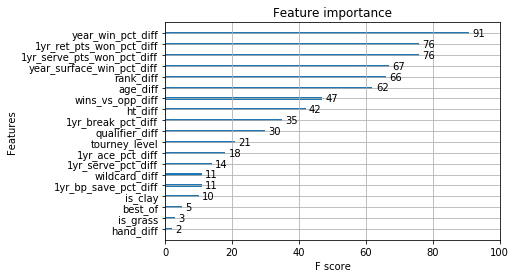

In [139]:
plot_importance(model)
pyplot.show()

In [166]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [172]:
y_pred = model.predict_proba(X_test)
y_pred

array([[0.59467983, 0.4053202 ],
       [0.41273165, 0.58726835],
       [0.53643584, 0.46356413],
       ...,
       [0.45461005, 0.54538995],
       [0.18592912, 0.8140709 ],
       [0.5745644 , 0.4254356 ]], dtype=float32)